# GNN for Learning Transferred Network-constrained Optimization Problems
## - An Optimal Power Flow Case
* Author: Shaohui Liu
* ECE, UT Austin
* Email: shaohui.liu@utexas.edu

In [1]:
#@title
!pip install dgl
import dgl

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

Using backend: pytorch


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data files
* Network has 24 nodes and 38 edges
* Uniform load (input) dataset
* 1 original network and 14 networks with topology disturbances and corresponding solutions
* Network perturbations generated by a random process following a binomial distribution 

In [2]:
# load the data files
# load 
filename = '/content/drive/My Drive/complex network/data/ieee24_topo_load.txt' # load file (no gen)
load_data = pd.read_table(filename,sep=',',header=None).to_numpy()

n_sample0 = np.size(load_data,1)

print(n_sample0,load_data.shape)

6000 (24, 6000)


* Load nominal system data

In [3]:
#@title
filename = '/content/drive/My Drive/gnn/data/ieee24_rts_8459_price.txt' # load file (no gen)
data = pd.read_table(filename,sep=',',header=None).to_numpy()

## load injection
# system size
n_bus  = int(data[0,0].copy())
n_line  = int(data[1,0].copy())
n_load  = int(data[2,0].copy())
# line
line_bus = data[:,1:3].copy()

# flow
filename = '/content/drive/My Drive/complex network/data/ieee24_topo_flow_nominal.txt'
flow_nominal = pd.read_table(filename,sep=',',header=None).to_numpy()
# print(flow_nominal.shape)
# generation
filename = '/content/drive/My Drive/complex network/data/ieee24_topo_gen_nominal.txt'
gen_nominal = pd.read_table(filename,sep=',',header=None).to_numpy()
# print(gen_nominal.shape)
# LMP
filename = '/content/drive/My Drive/complex network/data/ieee24_topo_lmp_nominal.txt'
lmp_nominal = pd.read_table(filename,sep=',',header=None).to_numpy()
print('Flow:',flow_nominal.shape,'Generation:',gen_nominal.shape,'LMP:',lmp_nominal.shape)

Flow: (38, 5994) Generation: (24, 5994) LMP: (24, 5994)


* Load perturbed system data

In [4]:
#@title
filename = '/content/drive/My Drive/complex network/data/ieee24_topo_effective_index.txt'
effective_index = pd.read_table(filename,sep=',',header=None).to_numpy()
print(effective_index.shape)

topo_pert_num = np.size(effective_index,1) - 1
print('Systems w/ topo. perturb:',topo_pert_num)

effective_samples0 = np.sum(effective_index[:,0],0)
effective_index0 = effective_index[:,0].copy()

effective_samples = np.sum(effective_index[:,1:],0)
print('Nominal effective samples:',effective_samples0)
print('Effective samples for topo. changes:',effective_samples)

(6000, 15)
Systems w/ topo. perturb: 14
Nominal effective samples: 5994
Effective samples for topo. changes: [5995 5998 5975 5999 5999 5998 5997 5998 5975 5999 5988 5980 5994 5997]


In [5]:
#@title

flow_pert = [] # list of np arries with length 5
gen_pert = []
lmp_pert = []
for i in range(topo_pert_num):
  # flow
  filename = '/content/drive/My Drive/complex network/data/ieee24_topo_flow_perturb'+ str(i+1) + '.txt'
  flow_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())
  # generation
  filename = '/content/drive/My Drive/complex network/data/ieee24_topo_gen_perturb'+ str(i+1) + '.txt'
  gen_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())
  # price
  filename = '/content/drive/My Drive/complex network/data/ieee24_topo_lmp_perturb'+ str(i+1) + '.txt'
  lmp_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())

# print(len(flow_pert))

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


There are 24 nodes.
There are 76 edges.


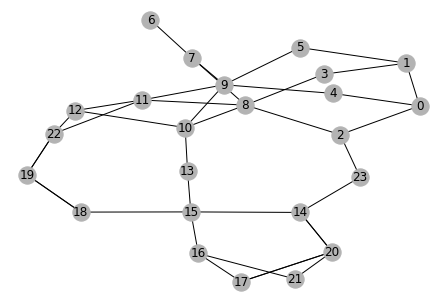

In [6]:
#@title
# Graph generating function
def build_system_graph(src,dst):
    # Edges are directional in DGL; Make them bi-directional.
    # Matlab counts from 1 and python from 0
    u = np.concatenate([src, dst])-1 
    v = np.concatenate([dst, src])-1
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

line_src = line_bus[:,0].copy()
line_dst = line_bus[:,1].copy()
G = build_system_graph(line_src.astype(int),line_dst.astype(int))
print('There are %d nodes.' % G.number_of_nodes())
print('There are %d edges.' % G.number_of_edges())

import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [7]:
#@title
print('Test summary:')
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples in load: ',n_sample0)
print('Number of effective samples in nominal system: ',effective_samples0)
print('Number of perturbation cases:',topo_pert_num)
print('Number of effective perturbation cases:',effective_samples)

Test summary:
Number of buses:  24
Number of lines:  38
Number of loads:  17
Number of samples in load:  6000
Number of effective samples in nominal system:  5994
Number of perturbation cases: 14
Number of effective perturbation cases: [5995 5998 5975 5999 5999 5998 5997 5998 5975 5999 5988 5980 5994 5997]


* Calculate laplacian 

In [8]:
#@title
line_src = line_bus[:,0].copy().astype(int)
line_dst = line_bus[:,1].copy().astype(int)
print('Original graph:')
print('There are %d nodes.' % n_bus)
print('There are %d edges.' % n_line)

# adjacency
def graph_v2v_mat(line,n_line,n_bus):
	w = np.zeros((n_bus,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		w[int(line[i,0])-1,int(line[i,1])-1] = 1
		w[int(line[i,1])-1,int(line[i,0])-1] = 1
	return w

def graph_laplacian(line,n_line,n_bus):
	incidence = np.zeros((n_line,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
	w = np.matmul(incidence.transpose(),incidence)
	return w
W = graph_laplacian(line_bus,n_line,n_bus) # v2v
# W=np.abs(W)

Original graph:
There are 24 nodes.
There are 38 edges.


* Generate training dataset

In [9]:
#@title
# load_data, gen_nominal, flow_nominal, lmp_nominal
# print(np.size(load_data,1))
# effective_samples0 = 5994 # done earlier
load_e0 = np.zeros((n_bus,effective_samples0))
idx = 0
for i in range(np.size(load_data,1)):
  if effective_index0[i] > 0:
    idx = idx + 1 
    load_e = load_data[:,i].copy()
    load_e0[:,idx - 1] = load_e.copy()
print(idx,load_e0.shape,load_data.shape)

5994 (24, 5994) (24, 6000)


In [10]:
print(load_e0.shape,gen_nominal.shape)

(24, 5994) (24, 5994)


In [11]:
#@title
# Set the ratio of training/test set
n_sample = effective_samples0
train_ratio = 0.9
n_train = int(np.floor(train_ratio * n_sample))
n_test = n_sample - n_train
print('Data set size: ',n_sample,', training set size: ',n_train,', test set size: ',n_test)

# Generate training set and test set
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(load_e0[0:n_bus,:].transpose(), gen_nominal.transpose(), test_size=1-train_ratio, random_state=23)
# print(x_train2.shape)
x_train = x_train2.transpose()
# print(x_train.shape)
x_test = x_test2.transpose()
y_train = y_train2.transpose()
y_test = y_test2.transpose()


# print('Training data size:',x_train.shape)
# print('Training label size:',y_train.shape)

def get_xy(index):
    tempx=np.array([np.transpose(x_train)[index]])
    x_train_one=torch.from_numpy(tempx).float()
    x_train_one=x_train_one.transpose(0,1)

    tempy=np.array([np.transpose(y_train)[index]])
    y_train_one=torch.from_numpy(tempy).float()
    y_train_one=y_train_one.transpose(0,1)

    return x_train_one,y_train_one

# generate torch y_train for concatenated obj
y_train1 = torch.from_numpy(y_train)#.float()
# expand into 3d tensor 
y_train1.unsqueeze_(-1)
y_train1 = y_train1.expand(n_bus,n_train,1)
y_train1 = y_train1.transpose(2,1)
print(y_train1.shape)

Data set size:  5994 , training set size:  5394 , test set size:  600
torch.Size([24, 1, 5394])


In [12]:
print(x_train.shape,y_train.shape)

(24, 5394) (24, 5394)


In [13]:
#@title
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(np.transpose(features)).float()
        self.labels = torch.from_numpy(np.transpose(labels)).float()
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = np.reshape(X,(1,24))
        y = np.reshape(y,(1,24))
        return X, y
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 3}

# Dataset Generators
training_set = Dataset(features=x_train, labels=y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(features=x_test, labels=y_test)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
#@title
from torch.autograd import Variable

# One layer Graph convolution from nodes to edges
class Graph_convolution0_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
#         self.Weight=nn.Parameter(torch.Tensor(W))
#         self.Weight=nn.Parameter(torch.from_numpy(W))
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        # self.scale=nn.Parameter(torch.Tensor(1,in_features))
        self.mapping = nn.Parameter(torch.Tensor(W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale.data) # initialize params
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)
        
    
    def forward(self,input):
        h = torch.mul(self.mapping,self.w)
        # print(h.shape,input.shape)
        h = torch.matmul(input,h) # transpose due to batch generator 
        h = torch.matmul(self.scale,h)
        return h + self.bias 
        # return torch.mul(h,self.scale) + self.bias 

# One layer n2n with flexible W
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,n,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        # self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        self.mapping = nn.Parameter(torch.Tensor(n,n))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale.data) # initialize params
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)
        
    
    def forward(self,input,W):
        h = torch.mul(self.mapping,W.transpose(0,1))
        # print(h.shape,input.shape)
        h = torch.matmul(input,h) # transpose due to batch generator 
        h = torch.matmul(self.scale,h)
        return h + self.bias 
        # return torch.mul(h,self.scale) + self.bias 



# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, n):
        super(GCN, self).__init__()
        self.conv_v2v1 = Graph_convolution_v2v_W(in_feats,hidden_size[0],n)
        self.conv_v2v2 = Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],n)
        self.conv_v2v3 = Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],n)
        self.conv_v2v4 = Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],n)
        # self.conv_v2v4 = Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W)
        self.conv_v2v5 = Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],n)
        self.conv_v2v6 = Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],n)
        self.conv_v2v7 = Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],n)
        self.conv_v2v8 = Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],n)
        
    def forward(self, inputs, w):
        W = torch.from_numpy(w).float()
        h = self.conv_v2v1(inputs, W)
        # h = torch.relu(h)
        h = self.conv_v2v2(h, W)
        h = torch.relu(h)
        h = self.conv_v2v3(h, W)
        # h = torch.relu(h)
        h = self.conv_v2v4(h, W)
        h = torch.relu(h)
        h = self.conv_v2v5(h, W)
        h = self.conv_v2v6(h, W)
        h = torch.relu(h)
        h = self.conv_v2v7(h, W)
        h = self.conv_v2v8(h, W)
        h = torch.relu(h)
        return h

w_params = [15,15,15,15,15,15,15,1]
net = GCN(1, w_params, n_bus) # Laplacian
# net = GCN(1, w_params, B)

# set loss_func & optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
loss_optm = []

# Model complexity

In [15]:
print(net)
n_params = 0
n_params_trainable = 0
for temp in net.parameters():
    # print(temp.shape[0])
    n_params += temp.shape[0] * temp.shape[1]
    if abs(temp.shape[0] - n_bus) > 0:
      n_params_trainable += temp.shape[0] * temp.shape[1]
    else:
      n_params_trainable += n_bus + 2 * n_line
print('Number of GNN parameters:',n_params)
print('Number of effective GNN parameters:',n_params_trainable)

GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (conv_v2v7): Graph_convolution_v2v_W()
  (conv_v2v8): Graph_convolution_v2v_W()
)
Number of GNN parameters: 6094
Number of effective GNN parameters: 2286


In [16]:
#@title
# # Load the pre-trained model
path = '/content/drive/My Drive/complex network/data/trained_model/ieee24_trained_params.pickle'
# torch.save(net.state_dict(), path)
# net_new = GCN(1, w_params, n_bus) # Laplacian
net.load_state_dict(torch.load(path))

# ## Training

# device = torch.device('cpu')
# max_epochs = 50
# for epoch in range(max_epochs):
#     # training loop
#     train_loss=0.0
#     for local_batch, local_labels in training_generator:
#         # Transfer to GPU
#         local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#         # print(local_batch.shape)
#         # print(local_batch)
#         # print(local_labels.shape)
#         logits = net(local_batch, W) # laplacian
#         loss = loss_func(logits, local_labels)
#         loss.backward()
#         train_loss+=loss.item()
#         optimizer.step()  # update parameters of net
#         optimizer.zero_grad()  # clear the psat gradient
#     loss_optm.append(train_loss/len(training_generator.dataset))
#     print("Epoch %d | Training loss: %.4f" % (epoch, train_loss/len(training_generator.dataset)))
#     # print("Epoch %d | Loss: %.4f" % (epoch, loss.item()))
#     # loss_optm.append(loss.item())
#     # validation loop
#     with torch.set_grad_enabled(False):
#         pass

<All keys matched successfully>

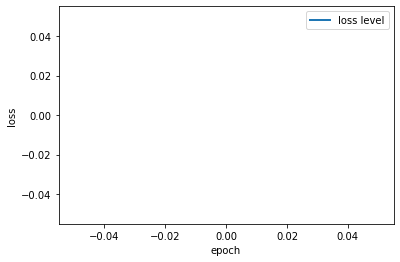

In [17]:
#@title
## Epoch 48 | Training loss: 3.9255 Epoch 49 | Training loss: 3.9356

import matplotlib.pyplot as plt
plt.figure()
plot_idx = np.arange(np.size(loss_optm))
plt.plot(plot_idx[2:-1],loss_optm[2:-1],lw=2,label='loss level')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# Evaluate the model w/ validation set

In [18]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed,W)

Validation dataset size: torch.Size([600, 1, 24])
Number of validation set:  600


 - Evaluate the trained model using validation set and visualize error

In [19]:
y_pred1 = y_pred.detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(24, 600)


In [20]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

err_expand = []
for i in range(10):
  err_expand.append(err_L2)
err_expand = np.array(err_expand)
print(err_L2.shape,err_expand.shape)

(600,) (10, 600)


# Visualization




L2 mean: 0.16902221226730088 L2 variance: 0.002249352120566277 L_inf mean: 0.24540546471396424


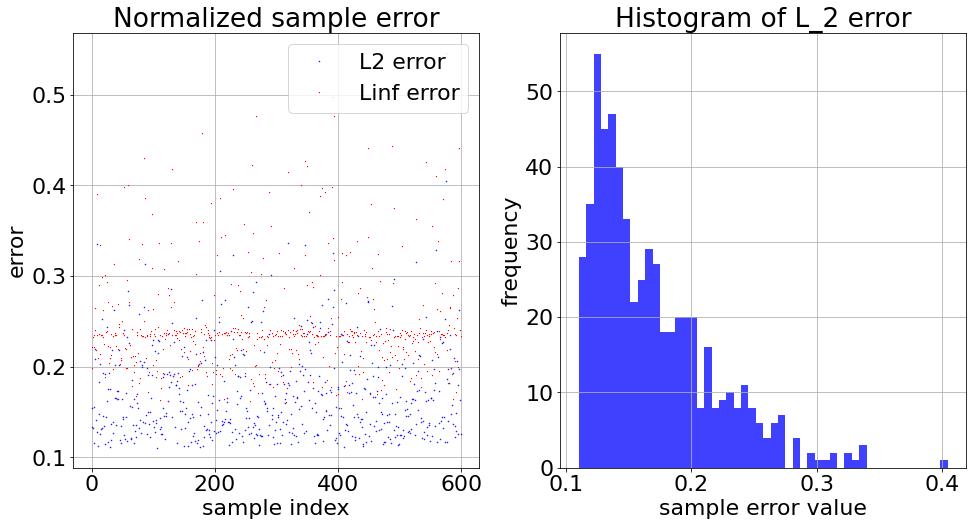

In [21]:
err_L2_mean = np.mean(err_L2)
err_L2_var = np.var(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

plt.rcParams.update({'font.size': 22})
fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Validate datasets with topology changes

In [22]:
print(gen_pert[0].shape)

# print(line_bus)
line_bus1 = np.delete(line_bus,0,0) # input: array, ojb, axis
# print(line_bus1)
W1 = graph_laplacian(line_bus1,n_line-1,n_bus) # v2v

(24, 5995)


In [23]:
print(effective_index.shape)

(6000, 15)


In [24]:
# gen_pert
load_e = []
for n_idx in range(topo_pert_num):
  # effective_samples = [5999,5994,5997,5992,5992]
  load_e1 = np.zeros((n_bus,effective_samples[n_idx]))
  idx = 0
  for i in range(np.size(load_data,1)):
    if effective_index[i][n_idx + 1] > 0:
      idx = idx + 1 
      load_e2 = load_data[:,i].copy()
      load_e1[:,idx - 1] = load_e2.copy()
  load_e.append(load_e1)
# print(idx,load_e1.shape,load_data.shape)

In [25]:
for i in range(topo_pert_num):
  print(load_e[i].shape,gen_pert[i].shape)

(24, 5995) (24, 5995)
(24, 5998) (24, 5995)
(24, 5975) (24, 5995)
(24, 5999) (24, 5995)
(24, 5999) (24, 5995)
(24, 5998) (24, 5995)
(24, 5997) (24, 5995)
(24, 5998) (24, 5995)
(24, 5975) (24, 5995)
(24, 5999) (24, 5995)
(24, 5988) (24, 5995)
(24, 5980) (24, 5995)
(24, 5994) (24, 5995)
(24, 5997) (24, 5995)


In [26]:
filename = '/content/drive/MyDrive/complex network/data/recorded_deletion_idx.txt' # load file (no gen)
del_idx = pd.read_table(filename,sep=',',header=None).to_numpy()
print(del_idx.shape)
del_num = np.sum(del_idx,0)
print(del_num.shape)
print(del_num)

(38, 14)
(14,)
[1 1 1 1 2 1 2 1 1 1 1 1 1 1]


In [27]:
print(del_idx[:,0])
# for i in range(5,0,-1):
#   print(i-1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0]


In [28]:
err_L2_tot = []
err_Linf_tot = []

for idx in range(topo_pert_num):
  x_feed = torch.from_numpy(np.transpose(load_e[idx])).float()
  x_feed = x_feed.unsqueeze_(-1).transpose(1,2)

  line_bus1 = line_bus.copy()
  for i in range(n_line,0,-1):
    if del_idx[i-1,idx] > 0:
      line_bus1 = np.delete(line_bus1,i-1,0) # input: array, ojb, axis

  W1 = graph_laplacian(line_bus1,n_line-del_num[idx],n_bus) # v2v

  y_pred1 = net(x_feed,W1) # prediction
  y_pred1 = y_pred1.detach()
  y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

  y_test00 = gen_pert[idx].copy()
  y_test = y_test00[:,0:effective_samples[idx]].copy()
  # print(y_test.shape,y_pred1.shape)

  n_test = np.size(y_test,1)
  err_L2 = np.zeros(n_test)
  err_Linf = np.zeros(n_test)
  for i in range(n_test):
    err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
    err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

  err_L2_tot.append(err_L2)
  err_Linf_tot.append(err_Linf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


In [29]:
# for i in range(topo_pert_num):
#   print(err_L2_tot[i].shape)
print(err_expand.shape)
err_expand1 = err_expand.reshape(600*10).tolist()

(10, 600)


# Validation visualization

In [30]:
#@title


L2 mean: 0.37274912341054395 L2 variance: 0.0056123311615690116 L_inf mean: 0.6287998452497574
L2 mean: 0.29315135348554 L2 variance: 0.0039853794715556355 L_inf mean: 0.34893900311359083
L2 mean: 0.30029131210905086 L2 variance: 0.0011977211467845592 L_inf mean: 0.34421739008318786
L2 mean: 0.24461785399049454 L2 variance: 0.0016310791625382068 L_inf mean: 0.27772785535321165
L2 mean: 0.3810719237666332 L2 variance: 0.003074823898286221 L_inf mean: 0.5310701212305371
L2 mean: 0.29315135348554 L2 variance: 0.0039853794715556355 L_inf mean: 0.34893900311359083
L2 mean: 0.3729384409556057 L2 variance: 0.0034819656126551 L_inf mean: 0.5094864827321659
L2 mean: 0.17128533651743882 L2 variance: 0.002046036922657578 L_inf mean: 0.24477487337129292
L2 mean: 0.30029131210905086 L2 variance: 0.0011977211467845592 L_inf mean: 0.34421739008318786
L2 mean: 0.24461785399049454 L2 variance: 0.0016310791625382068 L_inf mean: 0.27772785535321165
L2 mean: 0.17558006155462902 L2 variance: 0.002683796633

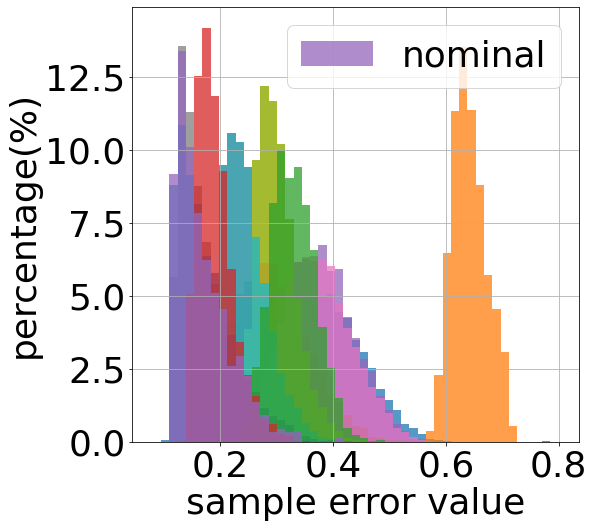

In [38]:
# import matplotlib
from matplotlib.ticker import PercentFormatter, FuncFormatter

#@title
for i in range(topo_pert_num):
  err_L2_mean = np.mean(err_L2_tot[i][0:5950])
  err_L2_var = np.var(err_L2_tot[i][0:5950])
  err_Linf_mean = np.mean(err_Linf_tot[i][0:5950])
  print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

plt.rcParams.update({'font.size': 36})
fig2 = plt.figure(figsize=(8, 8))
bins = np.linspace(0.08, 0.8, 50)
for i in range(topo_pert_num):
  name = 'sys' + str(i) + '('+ str(del_num[i]) + ')'
  # plt.hist(err_L2_tot[i], bins, alpha = 0.75, label = name)
  # weights=np.ones(len(err_L2_tot[i])) / len(err_L2_tot[i])
  plt.hist(np.asarray(err_L2_tot[i]), bins, density=True, alpha = 0.75)
name = 'nominal'
# weights=np.ones(len(err_expand1)) / len(err_expand1)
plt.hist(err_expand1, bins, density=True, alpha = 0.75, label = name)
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('percentage(%)')
# # Set the formatter
# def to_percent(y, position):
#     # Ignore the passed in position. This has the effect of scaling the default
#     # tick locations.
#     s = str(100 * y)

#     # The percent symbol needs escaping in latex
#     if matplotlib.rcParams['text.usetex'] is True:
#         return s + r'$\%$'
#     else:
#         return s + '%'
# formatter = FuncFormatter(to_percent)
# plt.gca().yaxis.set_major_formatter(formatter)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [32]:
a1 = np.asarray(err_L2_tot[1])
print(a1.shape)
# xxx = np.random.randn(5000)
# print(xxx.shape)
# plt.hist(xxx, bins=50, density=True)

(5995,)


# Use pre-trained net as warm start
* We only select a few datasets w/ large deviation
* 2,3,8,9,12

In [33]:
#@title
# net.state_dict()  # parameters
import copy
net_copy =  copy.deepcopy(net) # net.copy()
# print(net_copy)

# path = '/content/drive/My Drive/complex network/data/trained_model/ieee24_trained_params.pickle'
# torch.save(net.state_dict(), path)
# model = TheModelClass(*args, **kwargs)
net_new = GCN(1, w_params, n_bus) # Laplacian
net_new.load_state_dict(torch.load(path))
# model.eval()

<All keys matched successfully>

In [34]:
#@title
# train_key = [2,3,8,9,12]
train_key = [i for i in range(14)]
# train_key = [2]
device = torch.device('cpu')
max_epochs = 5

n_t = 5990

trainging_loss_topo = []
L2_loss = []
net_list = []

for idx in train_key:
  print('......')
  print('Start training for network:',idx)
  print('......')

  # Dataset Generators
  # x_train11 = []
  x_train11 = load_e[idx].copy()
  x_train11 = x_train11[:,:n_t]
  # x_train1 = torch.from_numpy(np.transpose(load_e[idx])).float()
  # y_test00 = []
  y_test00 = gen_pert[idx].copy()
  y_train11 = y_test00[:,0:effective_samples[idx]].copy()
  y_train11 = y_train11[:,:n_t]
  # print(x_train11.shape,y_train11.shape)

  x_train1 = x_train11
  x_test1 = x_train11
  y_train1 = y_train11
  y_test1 = y_train11

  # print(x_train1.shape,y_train1.shape)

  training_set = Dataset(features=x_train1, labels=y_train1)
  training_generator = torch.utils.data.DataLoader(training_set, **params)

  # generate a new net and import pre-trained net
  net_new = GCN(1, w_params, n_bus) # Laplacian
  net_new.load_state_dict(torch.load(path))

  # set the optimizer
  optimizer = torch.optim.Adam(net_new.parameters())

  # generate Laplacian matrix
  line_bus1 = line_bus.copy()
  for i in range(n_line,0,-1):
    if del_idx[i-1,idx] > 0:
      line_bus1 = np.delete(line_bus1,i-1,0) # input: array, ojb, axis
  W1 = graph_laplacian(line_bus1,n_line-del_num[idx],n_bus) # v2v

  # re-train the model
  loss_optm = []
  for epoch in range(max_epochs):
      # training loop
      train_loss=0.0
      for local_batch, local_labels in training_generator:
          # Transfer to GPU
          local_batch, local_labels = local_batch.to(device), local_labels.to(device)
          # print(local_batch.shape)
          # print(local_batch)
          # print(local_labels.shape)
          logits = net_new(local_batch, W1) # laplacian
          loss = loss_func(logits, local_labels)
          loss.backward()
          train_loss+=loss.item()
          optimizer.step()  # update parameters of net
          optimizer.zero_grad()  # clear the psat gradient
      loss_optm.append(train_loss/len(training_generator.dataset))
      print("Epoch %d | Training loss: %.4f" % (epoch, train_loss/len(training_generator.dataset)))
      # print("Epoch %d | Loss: %.4f" % (epoch, loss.item()))
      # loss_optm.append(loss.item())
      # validation loop
      with torch.set_grad_enabled(False):
          pass

  trainging_loss_topo.append(loss_optm)

  # store the trained model params
  net_list.append(net_new)
  path1 = '/content/drive/My Drive/complex network/data/trained_model/'
  name = 'ieee24_trained_params_sys' + str(idx) + '.pickle'
  torch.save(net_new.state_dict(), path1+name)
  
  x_feed = torch.from_numpy(np.transpose(x_test1)).float()
  x_feed = x_feed.unsqueeze_(-1).transpose(1,2)
  y_pred1 = net_new(x_feed,W1) # prediction
  y_pred1 = y_pred1.detach()
  y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

  # calculate the error
  n_test = np.size(y_test1,1)
  err_L2 = np.zeros(n_test)
  err_Linf = np.zeros(n_test)
  print(n_test,y_test1.shape,y_pred1.shape)
  for i in range(n_test):
    err_L2[i] = np.linalg.norm(y_pred1[:,i] - y_test1[:,i]) / np.linalg.norm(y_test1[:,i])
    err_Linf[i] = np.max(np.abs(y_pred1[:,i] - y_test1[:,i])) / np.max(np.abs(y_test1[:,i]))
  
  L2_loss.append(err_L2)
  err_L2_mean = np.mean(err_L2[:5950])
  err_L2_var = np.var(err_L2[:5950])
  err_Linf_mean = np.mean(err_Linf[:5950])
  print('......')
  print('System',idx)
  print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

......
Start training for network: 0
......


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 | Training loss: 7.0155
Epoch 1 | Training loss: 4.3115
Epoch 2 | Training loss: 4.1964
Epoch 3 | Training loss: 4.1674
Epoch 4 | Training loss: 4.1327
5990 (24, 5990) (24, 5990)
......
System 0
L2 mean: 0.16082908677235397 L2 variance: 0.0018897621033510694 L_inf mean: 0.23887226694864508
......
Start training for network: 1
......


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in double_scalars


Epoch 0 | Training loss: 5.7015
Epoch 1 | Training loss: 4.6111
Epoch 2 | Training loss: 4.5535
Epoch 3 | Training loss: 4.5430
Epoch 4 | Training loss: 4.5103
5990 (24, 5990) (24, 5990)
......
System 1
L2 mean: 0.16785991169784795 L2 variance: 0.0021995629259880206 L_inf mean: 0.2424971129893107
......
Start training for network: 2
......
Epoch 0 | Training loss: 6.6174
Epoch 1 | Training loss: 4.6236
Epoch 2 | Training loss: 4.5633
Epoch 3 | Training loss: 4.5540
Epoch 4 | Training loss: 4.5604
5975 (24, 5975) (24, 5975)
......
System 2
L2 mean: 0.1755858895987464 L2 variance: 0.0020959882896629703 L_inf mean: 0.25384959000253804
......
Start training for network: 3
......
Epoch 0 | Training loss: 5.2446
Epoch 1 | Training loss: 4.7533
Epoch 2 | Training loss: 4.7533
Epoch 3 | Training loss: 4.7216
Epoch 4 | Training loss: 4.7274
5990 (24, 5990) (24, 5990)
......
System 3
L2 mean: 0.17037960962963908 L2 variance: 0.002464681872528229 L_inf mean: 0.2457593499956727
......
Start traini

In [35]:
# print(n_test)
# # for i in range(14):
# #   print(load_e[i].shape,gen_pert[i].shape,effective_samples[i])
# for i in range(5):
#   # print(L2_loss[i])
#   print(L2_loss[i].shape)
# load_e0[0:n_bus,:].transpose(), gen_nominal.transpose()
x_feed = torch.from_numpy(np.transpose(load_e0[0:n_bus,:])).float()
x_feed = x_feed.unsqueeze_(-1).transpose(1,2)
y_pred1 = net(x_feed,W) # prediction
y_pred1 = y_pred1.detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

# calculate the error
n_test = np.size(y_test1,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
print(n_test,y_test1.shape,y_pred1.shape)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_pred1[:,i] - gen_nominal[:,i]) / np.linalg.norm(gen_nominal[:,i])
  err_Linf[i] = np.max(np.abs(y_pred1[:,i] - gen_nominal[:,i])) / np.max(np.abs(gen_nominal[:,i]))
print(np.mean(err_L2[:5900]),np.mean(err_Linf[:5900]))

5990 (24, 5990) (24, 5994)
0.16651664364155053 0.24297497446680763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


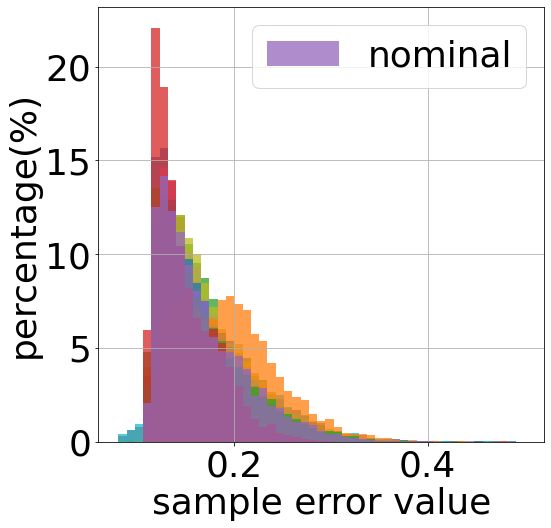

In [39]:
# train_key = [2,3,8,9,12]

plt.rcParams.update({'font.size': 36})
fig2 = plt.figure(figsize=(8, 8))
bins = np.linspace(0.08, 0.5, 50)
for i in range(len(train_key)):
  name = 'sys' + str(train_key[i]) + '('+ str(del_num[train_key[i]]) + ')'
  # plt.hist(L2_loss[i], bins, alpha = 0.75, label = name)
  plt.hist(L2_loss[i], bins, density=True, alpha = 0.75)
name = 'nominal'
plt.hist(err_L2, bins, density=True, alpha = 0.75, label = name)
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('percentage(%)')
# plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()